# Bài tập 1: Gaussian Mixture Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GaussianMixture:
    def __init__(self, n_components) -> None:
        self.n_components = n_components
        self.max_iter = 100
        self.log_likelihood = -np.inf
        self.means = None
        self.weights = None
        self.covariances = None

    def initialize(self, x) -> None:
        x_n, x_m = x.shape
        self.weights = np.ones(self.n_components) / self.n_components
        indices = np.random.choice(x_n, self.n_components, replace=False)
        self.means = x[indices]
        self.covariances = [np.eye(x_m) for _ in range(self.n_components)]
    
    def multivariate_normal(self, x, mean, cov) -> np.ndarray:
        d = mean.shape[0]
        diff = x - mean

        det_cov = np.linalg.det(cov)
        inv_cov = np.linalg.inv(cov)

        norm_const = 1 / ((2*np.pi)**(d/2) * np.sqrt(det_cov))
        exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
        return norm_const * np.exp(exponent)
            
    def fit(self, x) -> None:
        self.initialize(x)
        for _ in range(self.max_iter):
            # E-step:
            likelihood = np.zeros((x.shape[0], self.n_components))
            for k in range(self.n_components):
                likelihood[:, k] = self.weights[k] * self.multivariate_normal(x, self.means[k], self.covariances[k])
            likelihood = likelihood / likelihood.sum(axis=1, keepdims=True)

            # M-step:
            N_k = likelihood.sum(axis=0)
            self.weights = N_k / x.shape[0]
            self.means = np.dot(likelihood.T, x) / N_k[:, np.newaxis]

            for k in range(self.n_components):
                diff = x - self.means[k]
                self.covariances[k] = (likelihood[:, k] * diff.T) @ diff / N_k[k]
            
            # Check
            new_log_likelihood = np.log(likelihood.sum(axis=1)).sum()
            if new_log_likelihood == self.log_likelihood:
                break
            self.log_likelihood = new_log_likelihood

    def predict(self, x):
        likelihood = np.zeros((x.shape[0], self.n_components))
        for k in range(self.n_components):
            likelihood[:, k] = self.weights[k] * self.multivariate_normal(x, self.means[k], self.covariances[k])
        likelihood = likelihood / likelihood.sum(axis=1, keepdims=True)
        return np.argmax(likelihood, axis=1)

# Bài tập 2: Extract foreground

In [3]:
import os
from skimage.io import imread
from skimage.transform import resize

In [4]:
!gdown 15NNnaeDdAIfyTNI6hEAper8c5dSsidh5

Downloading...
From: https://drive.google.com/uc?id=15NNnaeDdAIfyTNI6hEAper8c5dSsidh5
To: /workspaces/DS102_23521565_Lab5/cow.jpg
100%|██████████████████████████████████████| 16.9k/16.9k [00:00<00:00, 39.9MB/s]


In [5]:
image = imread(os.path.join('cow.jpg'))
image = resize(image, (68, 80), anti_aliasing=True)
pixels = image.reshape(-1, 3)

In [6]:
gmm = GaussianMixture(n_components=3)
gmm.fit(pixels)
labels = gmm.predict(pixels)

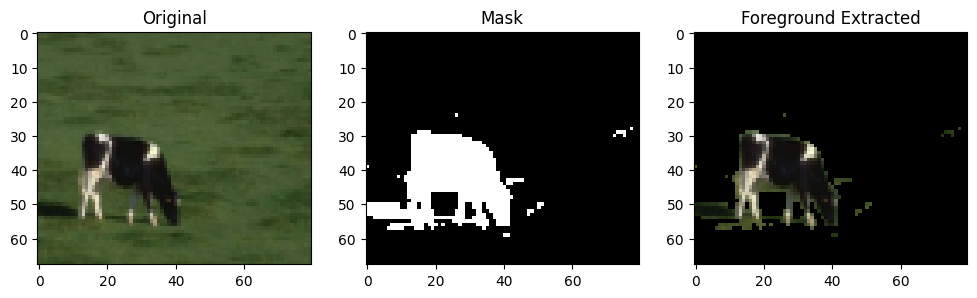

In [7]:
# Background
bg_label = np.bincount(labels).argmax()

# Extract foreground
mask = (labels != bg_label).astype(np.uint8).reshape(image.shape[:2])
mask_rgb = np.stack([mask]*3, axis=-1)
foreground = image * mask_rgb

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Foreground Extracted")
plt.imshow(foreground)
plt.show()